In [1]:
#This portion of the project was written by Aidan Riley

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import skimage

fid = h5py.File('dataset_patchcamelyon.h5','r')
fid.keys()

X, Y = fid["X"][:], fid["Y"][:]
X = X / 255.
fid.close()

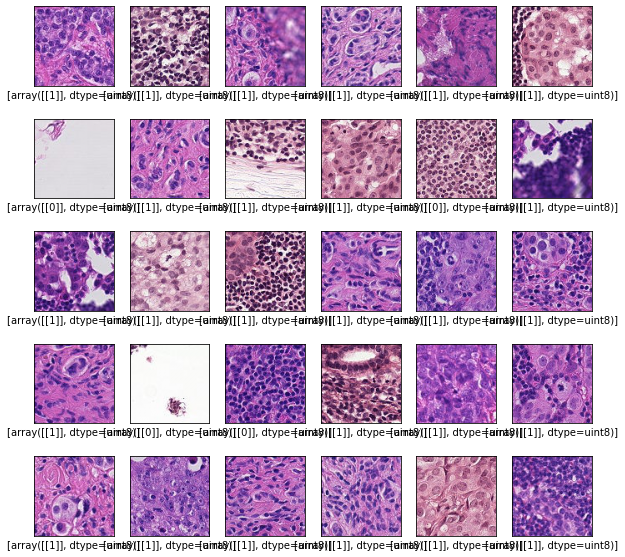

In [2]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel([Y[i][0]])
plt.show()


In [8]:
#See the distribution between cancerous and noncancerous entries
print(np.sum(Y==1),'cancerous entries')
print(np.sum(Y==0),'non-cancerous entries')

1316 cancerous entries
1184 non-cancerous entries


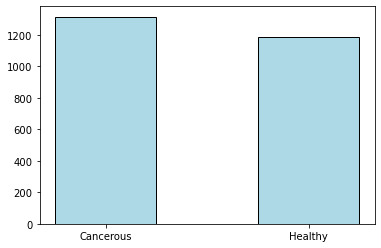

In [181]:
#Analyzing the distribution of the target variables
labels = ['Cancerous','Healthy']
cancerous = np.sum(Y==1)
healthy = np.sum(Y==0)

plt.figure()
plt.bar([0,1],[cancerous,healthy],width=0.5,color = 'lightblue',edgecolor = 'black')
plt.xticks(np.linspace(0,1,2),labels)
plt.savefig('initial_distribution.png')


#Looks like a roughly even split

In [182]:
#Lets split the Data
from sklearn.model_selection import train_test_split



X_train, X_test ,Y_train,Y_test= train_test_split(X, Y, test_size=0.20, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.25, random_state=42)

(1500, 96, 96, 3)
(500, 96, 96, 3)
(500, 96, 96, 3)


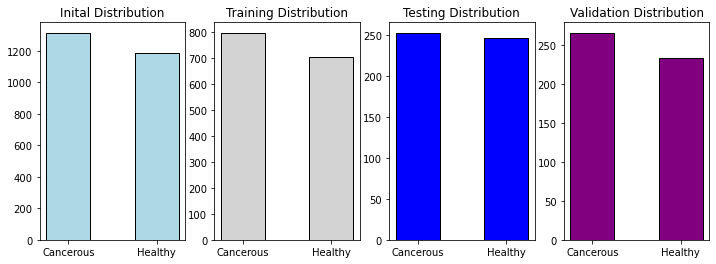

In [185]:

#Checking the shape of the two datasets
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.bar([0,1],[cancerous,healthy],width=0.5,color = 'lightblue',edgecolor = 'black')
plt.xticks(np.linspace(0,1,2),labels)
plt.title('Inital Distribution')
plt.subplot(1,4,2)
plt.bar([0,1],[np.sum(Y_train==1),np.sum(Y_train==0)],width=0.5,color = 'lightgrey',edgecolor = 'black')
plt.xticks(np.linspace(0,1,2),labels)
plt.title('Training Distribution')
plt.subplot(1,4,3)
plt.bar([0,1],[np.sum(Y_test==1),np.sum(Y_test==0)],width=0.5,color = 'blue',edgecolor = 'black')
plt.xticks(np.linspace(0,1,2),labels)
plt.title('Testing Distribution')
plt.subplot(1,4,4)
plt.bar([0,1],[np.sum(Y_val==1),np.sum(Y_val==0)],width=0.5,color = 'purple',edgecolor = 'black')
plt.xticks(np.linspace(0,1,2),labels)
plt.title('Validation Distribution')
plt.savefig('split_distributions.png')

#Distribution still looks good

In [76]:
#Flattening the data
X_train_flat = X_train.reshape(1500,-1)
Y_train_flat = Y_train.reshape(1500,-1)

X_test_flat = X_test.reshape(500,-1)
Y_test_flat = Y_test.reshape(500,-1)

X_val_flat = X_val.reshape(500,-1)
Y_val_flat = Y_val.reshape(500,-1)

#Checking to make sure that the reshaping moved elements as expected
# print(X_train[1])
# print(X_train_flat[1])
print(X_train_flat[0])

[0.78431373 0.4627451  0.60392157 ... 0.74117647 0.53333333 0.61176471]


In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score, completeness_score

####This section of the code was written with the motivation of creating a figure that demonstrates how clustering
####will not accurately split the data, however, it has been omitted from the report as I do not believe it makes
####sense to analyze the 2 dimensions that can be plotted


#Analyzing the possiblity of clustering the data for dimensionality reduction
distortions = []
avg_silhouette = [0]
completeness = [0]

# for each number of clusters in the assigned range...
for i in range(1, 10):
    km_tmp = KMeans(n_clusters = i, init='random', n_init=15, max_iter=500, tol=1e-04, random_state=36)
    y_pred_tmp = km_tmp.fit_predict(X_train_flat)
    distortions.append(km_tmp.inertia_)
    if (i>1):
        avg_silhouette.append(silhouette_score(X_train_flat, y_pred_tmp, metric='euclidean'))





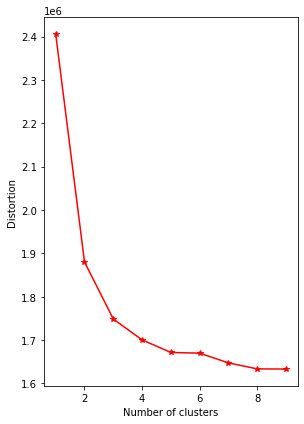

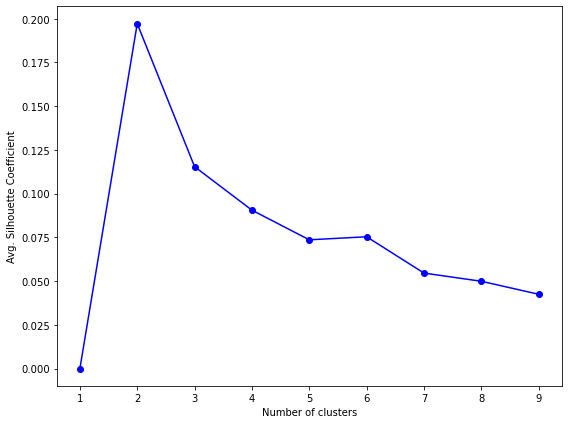

In [78]:
#plot the distortion values versus the number of clusters
plt.figure(1, figsize=(8, 6))
plt.subplot(1,2,1)

plt.plot(range(1, 10), distortions, marker='*',color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

#plot the average silhouette coefficients versus the number of clusters
plt.figure(2,figsize=(8,6))
plt.plot(range(1, 10), avg_silhouette, marker='o',color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Avg. Silhouette Coefficient')
plt.tight_layout()
plt.show()


In [79]:
#Lets visualize this clustering
#2 clusters seems to perform the best, the same number of output labels we are looking at
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(X_train_flat)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=15)
kmeans.fit(reduced_data)



KMeans(n_clusters=2, n_init=15)

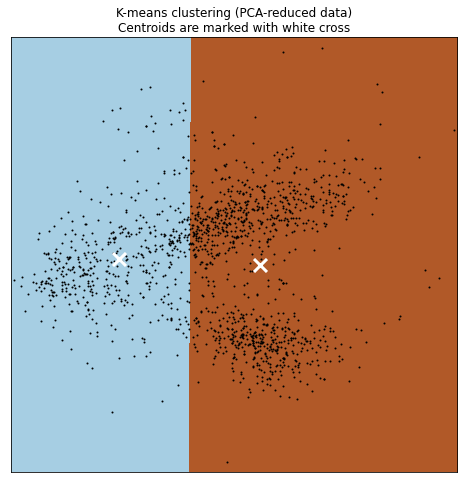

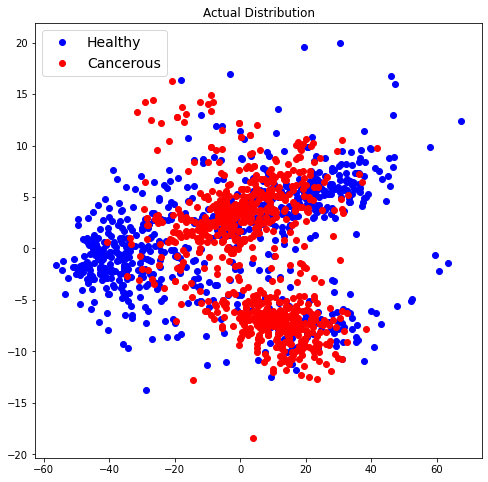

Binary PCA does not look too good!


In [80]:
# Step size of the mesh
h = .01

# Plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(figsize=(8,8))
plt.plot(reduced_data[:,:1][Y_train_flat==0], reduced_data[:,1:2][Y_train_flat==0], "bo",label="Healthy")
plt.plot(reduced_data[:, :1][Y_train_flat==1], reduced_data[:, 1:2][Y_train_flat==1], "ro",label="Cancerous")

plt.title('Actual Distribution')
plt.legend(loc="upper left", fontsize=14)
plt.show()

print('Binary PCA does not look too good!')

(500, 96, 96)


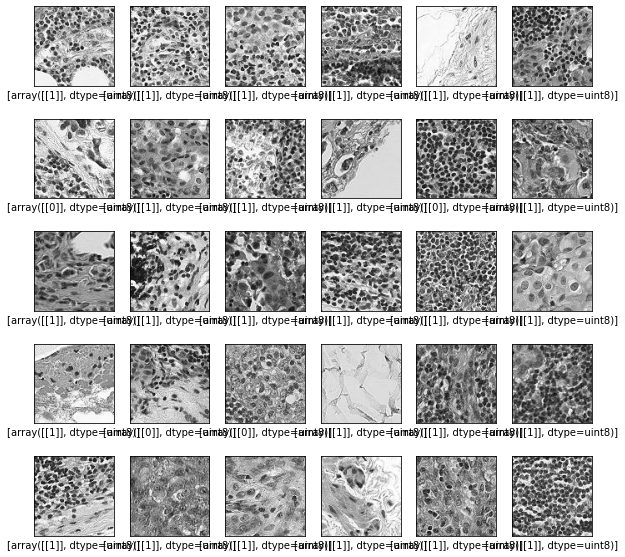

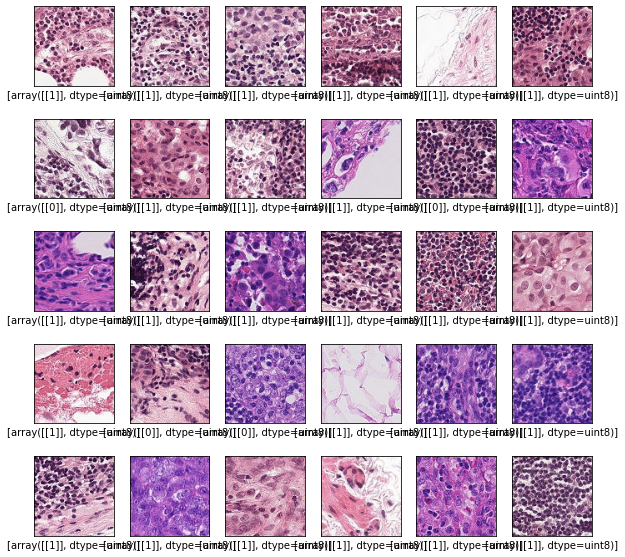

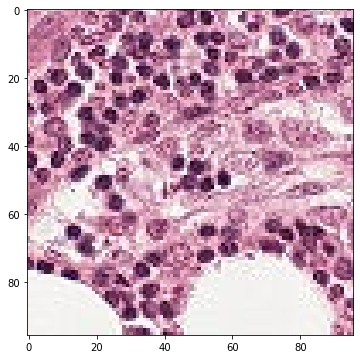

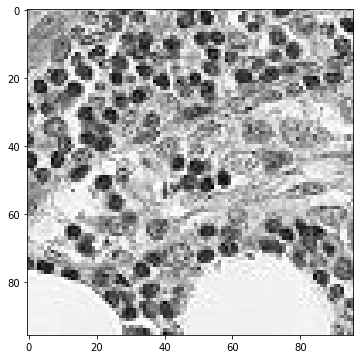

In [83]:
#Lets compare SVC on greyscale image vs the whole dataset
from sklearn.svm import SVC

X_train_grey = np.mean(X_train,3)
X_train_grey.shape


X_test_grey = np.mean(X_test,3)
print(X_test_grey.shape)

X_val_grey = np.mean(X_val,3)

X_train_grey = 1 - X_train_grey
#Checking that greyscale operation indeed worked as expected
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_grey[i], cmap=plt.cm.binary)
    plt.xlabel([Y[i][0]])
plt.show()
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel([Y[i][0]])
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(X_train[0],cmap=plt.cm.binary)
plt.savefig('standard.png')

plt.figure(figsize=(6,6))
plt.imshow(X_train_grey[0],cmap=plt.cm.binary)
plt.savefig('greyscale.png')

X_train_grey = X_train_grey.reshape(1500,-1)
X_test_grey = X_test_grey.reshape(500,-1)
X_val_grey = X_val_grey.reshape(500,-1)

In [189]:
#Lets see how all the data performs using an SVM classifier
base_clf = SVC(kernel='rbf',degree=3,random_state=36,decision_function_shape='ovo',probability=True)
base_clf.fit(X_train_flat,Y_train_flat)

svm_predictions = base_clf.predict(X_val_flat)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.756
Precision Score is 
 0.7368421052631579
Recall Score is 
 0.8421052631578947
F1 Score is 
 0.7859649122807016


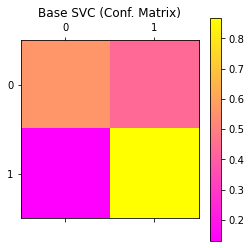

In [205]:
#Calculating the Accuracry Metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

   
prec_svm = precision_score(Y_val_flat,svm_predictions)
rec_svm = recall_score(Y_val_flat,svm_predictions)
f1_svm = f1_score(Y_val_flat,svm_predictions)
acc_svm = accuracy_score(Y_val_flat,svm_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_svm)
print('Precision Score is','\n', prec_svm)
print('Recall Score is', '\n',rec_svm)
print('F1 Score is','\n',f1_svm)

#Confusion and Error Matricies
CM_svm = confusion_matrix(Y_val_flat, base_predictions)

CM_svm = CM_svm.astype('float') / CM_svm.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_svm, cmap=plt.cm.spring)
plt.title('Base SVC (Conf. Matrix)')
plt.tight_layout
plt.colorbar()


plt.savefig('base_cm.png')

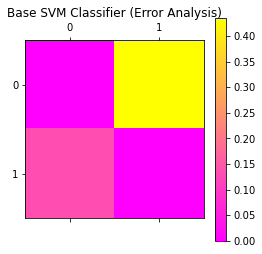

In [226]:
np.fill_diagonal(CM_svm,0)

plt.matshow(CM_svm, cmap=plt.cm.spring)
plt.title('Base SVM Classifier (Error Analysis)')
plt.tight_layout
plt.colorbar()

plt.savefig('err_SVM.png')

In [90]:
from sklearn.ensemble import BaggingClassifier



bagger = BaggingClassifier(base_clf,bootstrap=True,max_samples=100)

bagger.fit(X_train_flat,Y_train_flat)


base_predictions = bagger.predict(X_val_flat)


C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.726
Precision Score is 
 0.6936936936936937
Recall Score is 
 0.868421052631579
F1 Score is 
 0.7712854757929885
Bagging Shows No Improvement over the standard SVC


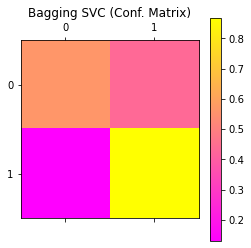

In [204]:
#Calculating the Accuracry Metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

   
prec_base = precision_score(Y_val_flat,base_predictions)
rec_base = recall_score(Y_val_flat,base_predictions)
f1_base = f1_score(Y_val_flat,base_predictions)
acc_base = accuracy_score(Y_val_flat,base_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_base)
print('Precision Score is','\n', prec_base)
print('Recall Score is', '\n',rec_base)
print('F1 Score is','\n',f1_base)

#Confusion and Error Matricies
CM_base = confusion_matrix(Y_val_flat, base_predictions)

CM_base = CM_base.astype('float') / CM_base.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_base, cmap=plt.cm.spring)
plt.title('Bagging SVC (Conf. Matrix)')
plt.tight_layout
plt.colorbar()


plt.savefig('bagging_cm.png')
print('Bagging Shows No Improvement over the standard SVC')

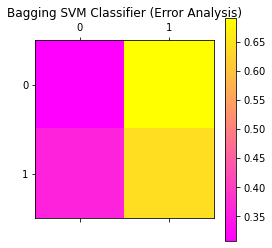

<Figure size 432x288 with 0 Axes>

In [92]:
np.fill_diagonal(CM_svm,0)

plt.matshow(CM_base, cmap=plt.cm.spring)
plt.title('Bagging SVM Classifier (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.show()
plt.savefig('err_base.png')

In [197]:
#Lets compare this to a random arrangement of the columns to demonstrate if the Flattening of the image retains information

random_train = X_train_flat[:, np.random.permutation(X_train_flat.shape[1])]
random_test = X_test_flat[:,np.random.permutation(X_test_flat.shape[1])]
random_val = X_val_flat[:,np.random.permutation(X_val_flat.shape[1])]

base_clf.fit(random_train,Y_train_flat)

random_predictions = base_clf.predict(random_val)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.716
Precision Score is 
 0.8131313131313131
Recall Score is 
 0.6052631578947368
F1 Score is 
 0.6939655172413793
Random permutations of the columns perform similar to the standard data


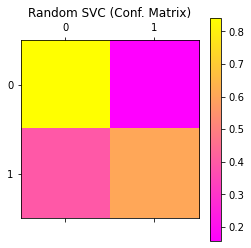

In [206]:
prec_random = precision_score(Y_val_flat,random_predictions)
rec_random = recall_score(Y_val_flat,random_predictions)
f1_random = f1_score(Y_val_flat,random_predictions)
acc_random = accuracy_score(Y_val_flat,random_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_random)
print('Precision Score is','\n', prec_random)
print('Recall Score is', '\n',rec_random)
print('F1 Score is','\n',f1_random)

#Confusion and Error Matricies
CM_random = confusion_matrix(Y_val_flat, random_predictions)

CM_random = CM_random.astype('float') / CM_random.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_random, cmap=plt.cm.spring)
plt.title('Random SVC (Conf. Matrix)')
plt.tight_layout
plt.colorbar()


plt.savefig('random_cm.png')

print('Random permutations of the columns perform similar to the standard data')

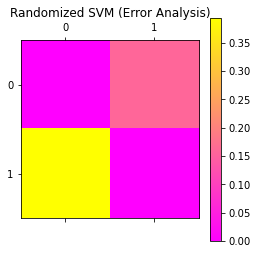

In [227]:
np.fill_diagonal(CM_random,0)

plt.matshow(CM_random, cmap=plt.cm.spring)
plt.title('Randomized SVM (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.savefig('err_random.png')

In [153]:
#Compare with greyscale




base_clf.fit(X_train_grey,Y_train_flat)

grey_predictions = base_clf.predict(X_val_grey)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.43
Precision Score is 
 0.2978723404255319
Recall Score is 
 0.05263157894736842
F1 Score is 
 0.08945686900958465


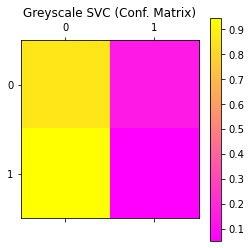

In [207]:
prec_grey = precision_score(Y_val_flat,grey_predictions)
rec_grey = recall_score(Y_val_flat,grey_predictions)
f1_grey = f1_score(Y_val_flat,grey_predictions)
acc_grey = accuracy_score(Y_val_flat,grey_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_grey)
print('Precision Score is','\n', prec_grey)
print('Recall Score is', '\n',rec_grey)
print('F1 Score is','\n',f1_grey)

#Confusion and Error Matricies
CM_grey = confusion_matrix(Y_val_flat, grey_predictions)

CM_grey = CM_grey.astype('float') / CM_grey.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_grey, cmap=plt.cm.spring)
plt.title('Greyscale SVC (Conf. Matrix)')
plt.tight_layout
plt.colorbar()


plt.savefig('greyscale_cm.png')



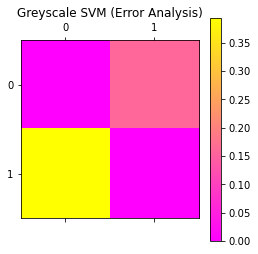

In [228]:
np.fill_diagonal(CM_grey,0)

plt.matshow(CM_random, cmap=plt.cm.spring)
plt.title('Greyscale SVM (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.savefig('err_grey.png')

(500, 96, 96, 3)
(500, 24, 24, 3)
(1500, 24, 24, 3)


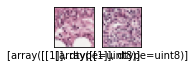

In [110]:
from skimage.transform import downscale_local_mean
print(X_test.shape)

X_train_downscale = np.zeros(shape=(1500,24,24,3))
X_test_downscale = np.zeros(shape=(500,24,24,3))
X_val_downscale = np.zeros(shape=(500,24,24,3))


#Sample to lower resolution than I would have liked to run PCA on the data

for i in range((X_train.shape[0])):
    X_train_downscale[i] = downscale_local_mean(X_train[i],(4,4,1))

for j in range((X_test.shape[0])):
    X_test_downscale[j] = downscale_local_mean(X_test[j],(4,4,1))
    
for k in range((X_val.shape[0])):
    X_val_downscale[k] = downscale_local_mean(X_val[k],(4,4,1))

print(X_test_downscale.shape)
print(X_train_downscale.shape)
    
plt.figure(figsize=(5,6))
for i in range(2):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_downscale[i], cmap=plt.cm.binary)
    plt.xlabel([Y[i][0]])
plt.savefig('local_mean_reduction.png')
# plt.figure(figsize=(10,10))
# for i in range(10):
#     plt.subplot(5,6,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(X_train[i], cmap=plt.cm.binary)
#     plt.xlabel([Y[i][0]])
# plt.show()

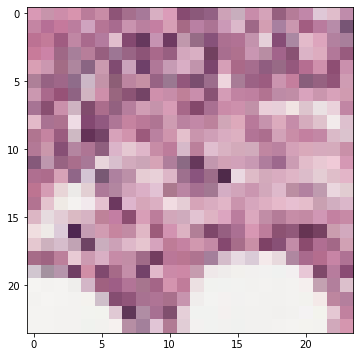

In [111]:
plt.figure(figsize=(6,6))
plt.imshow(X_train_downscale[0])
plt.savefig('local_mean_reduction.png')

(1500,)
463 components of the total 1500 components account for 98% of variance


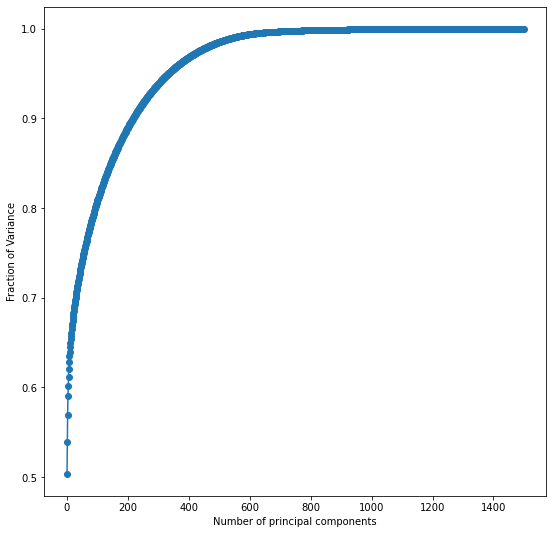

In [114]:
#We now have a downscaled image, lets run PCA
#PCA analysis to determine optimal n 
from sklearn.decomposition import PCA

X_test_downscale = X_test_downscale.reshape(500,-1)
X_val_downscale = X_val_downscale.reshape(500,-1)
X_train_downscale = X_train_downscale.reshape(1500,-1)
X_train_downscale.shape


pcaval = PCA(svd_solver='auto')
pcaval.fit(X_train_downscale)

# compute how much variance is explained by each component
CUMSUM = np.cumsum(pcaval.explained_variance_ratio_)
print(CUMSUM.shape)

plt.figure(figsize=(9,9))
plt.plot(range(1500), CUMSUM, marker='o')
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of Variance')
plt.savefig('Local Mean pca analysis.png')

# print out how many components explain at least 95% of the variance
dmax = np.argmax(CUMSUM >= 0.98) + 1
print(dmax,"components of the total", pcaval.explained_variance_ratio_.size, "components account for 98% of variance")

In [132]:
#Lets Create a pipe using SVC with our downsample images and PCA reduction
from sklearn.pipeline import Pipeline
print(X_train_downscale.shape)
print(X_test_downscale.shape)


n = 463

pipe = Pipeline([('PCA',PCA(n_components = n)),('bag',BaggingClassifier(base_clf,bootstrap=True,max_samples=100))])
pipe.fit(X_train_downscale,Y_train_flat)

pipe_predictions = pipe.predict(X_val_downscale)

(1500, 1728)
(500, 1728)


C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.72
Precision Score is 
 0.6956521739130435
Recall Score is 
 0.8421052631578947
F1 Score is 
 0.761904761904762


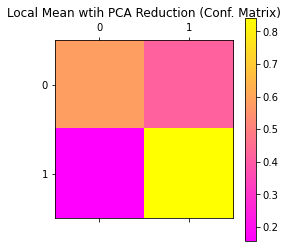

In [208]:
prec_pipe = precision_score(Y_val_flat,pipe_predictions)
rec_pipe = recall_score(Y_val_flat,pipe_predictions)
f1_pipe = f1_score(Y_val_flat,pipe_predictions)
acc_pipe = accuracy_score(Y_val_flat,pipe_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_pipe)
print('Precision Score is','\n', prec_pipe)
print('Recall Score is', '\n',rec_pipe)
print('F1 Score is','\n',f1_pipe)

#Confusion and Error Matricies
CM_pipe = confusion_matrix(Y_val_flat, pipe_predictions)

CM_pipe = CM_pipe.astype('float') / CM_pipe.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_pipe, cmap=plt.cm.spring)
plt.title('Local Mean wtih PCA Reduction (Conf. Matrix)')
plt.tight_layout
plt.colorbar()

plt.savefig('local_mean_cm.png')


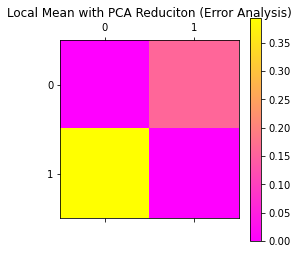

In [229]:
np.fill_diagonal(CM_pipe,0)

plt.matshow(CM_random, cmap=plt.cm.spring)
plt.title('Local Mean with PCA Reduciton (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.savefig('err_local_mean.png')

In [155]:
#Lets compare to the same classifier with no PCA

# scaled_clf = BaggingClassifier(base_clf,bootstrap=True,max_samples=100)
base_clf.fit(X_train_downscale,Y_train_flat)
scaled_predictions = base_clf.predict(X_val_downscale)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.768
Precision Score is 
 0.7403846153846154
Recall Score is 
 0.868421052631579
F1 Score is 
 0.7993079584775087
Predictably better without pca


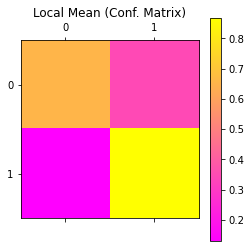

In [217]:
prec_scaled = precision_score(Y_val_flat,scaled_predictions)
rec_scaled = recall_score(Y_val_flat,scaled_predictions)
f1_scaled = f1_score(Y_val_flat,scaled_predictions)
acc_scaled = accuracy_score(Y_val_flat,scaled_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_scaled)
print('Precision Score is','\n', prec_scaled)
print('Recall Score is', '\n',rec_scaled)
print('F1 Score is','\n',f1_scaled)

#Confusion and Error Matricies
CM_scaled = confusion_matrix(Y_val_flat, scaled_predictions)

CM_scaled = CM_scaled.astype('float') / CM_scaled.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_scaled, cmap=plt.cm.spring)
plt.title('Local Mean (Conf. Matrix)')
plt.tight_layout
plt.colorbar()
plt.savefig('local_mean_without_pca')


print('Predictably better without pca')

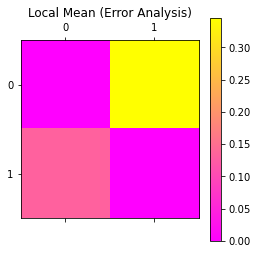

In [233]:
np.fill_diagonal(CM_scaled,0)

plt.matshow(CM_scaled, cmap=plt.cm.spring)
plt.title('Local Mean (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.savefig('err_local_mean.png')

In [141]:
#Tuning the hyperparameters of the SVC classifier used in the bagging routine
from sklearn.model_selection import GridSearchCV

opt_pipe = Pipeline([('PCA',PCA()),('SVC',SVC())])

opt_clf =GridSearchCV(estimator=opt_pipe,param_grid = {'PCA__n_components':[n],'SVC__kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'SVC__C':[0.01,0.1,1,10]},cv=5)

opt_clf.fit(X_train_downscale,Y_train_flat)

print('Best Parameters are:',opt_clf.best_params_)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

Best Parameters are: {'PCA__n_components': 463, 'SVC__C': 1, 'SVC__kernel': 'rbf'}


In [215]:
#Test with and without bagging
opt_pipe = Pipeline([('PCA',PCA(n_components=463)),('Bagging',BaggingClassifier(SVC(C = 1, kernel='rbf',probability=True)))])

opt_pipe.fit(X_train_downscale,Y_train_flat)
opt_predictions = opt_pipe.predict(X_val_downscale)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.76
Precision Score is 
 0.7433333333333333
Recall Score is 
 0.8383458646616542
F1 Score is 
 0.7879858657243817
Hyperparameters show slight improvement


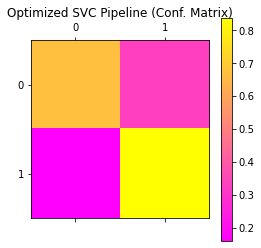

In [216]:
prec_opt = precision_score(Y_val_flat,opt_predictions)
rec_opt = recall_score(Y_val_flat,opt_predictions)
f1_opt = f1_score(Y_val_flat,opt_predictions)
acc_opt = accuracy_score(Y_val_flat,opt_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_opt)
print('Precision Score is','\n', prec_opt)
print('Recall Score is', '\n',rec_opt)
print('F1 Score is','\n',f1_opt)

#Confusion and Error Matricies
CM_opt = confusion_matrix(Y_val_flat, opt_predictions)

CM_opt = CM_opt.astype('float') / CM_opt.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_opt, cmap=plt.cm.spring)
plt.title('Optimized SVC Pipeline (Conf. Matrix)')
plt.tight_layout
plt.colorbar()
plt.savefig('optimized_pipeline.png')

print('Hyperparameters show slight improvement')

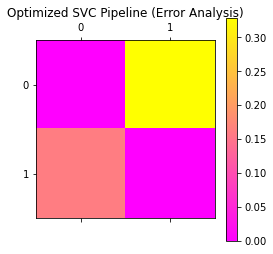

<Figure size 432x288 with 0 Axes>

In [231]:
np.fill_diagonal(CM_opt,0)

plt.matshow(CM_opt, cmap=plt.cm.spring)
plt.title('Optimized SVC Pipeline (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.show()
plt.savefig('err_optimized_pipeline.png')

Figure demonstrates the discrepancies between predict and predict_proba for SVC outlined in the user manual


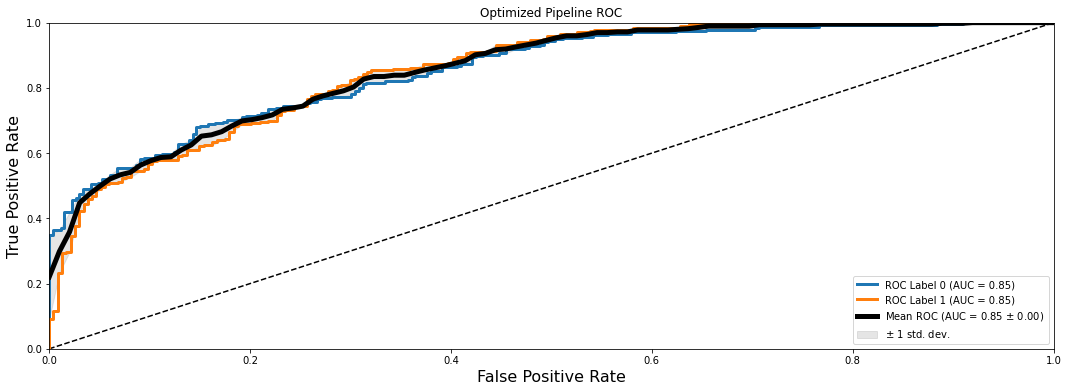

In [166]:
#ROC Curve
from sklearn.metrics import auc

Fpr_mean = np.linspace(0, 1, 100)
tpr_mean = []
Fpr = []
Tpr = []
AUC = []

for i in range(np.size(opt_probs,1)):
    probs = opt_probs[:,i]
    true = Y_val_flat==i
    fpr,tpr,thresh = roc_curve(true,probs)
    AUC.append(roc_auc_score(true,probs))
    Fpr.append(fpr)
    Tpr.append(tpr)
    tpr_mean.append(np.interp(Fpr_mean,fpr,tpr))

    
# compute the mean and SD for the TPR sequence and the AUC
Tpr_mean = np.mean(tpr_mean, axis=0)
Tpr_stdv = np.std(tpr_mean, axis=0)

mean_auc = auc(Fpr_mean, Tpr_mean)
std_auc = np.std(AUC)

# make the plot: frame
plt.figure(1, figsize=(18, 6))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Optimized Pipeline ROC')

# plot the individual ROC curves
for i in range(0,np.size(opt_probs,1)):
    plt.plot(Fpr[i],Tpr[i], linewidth=3, label=r'ROC Label %d (AUC = %0.2f)' % (i,AUC[i]))

# plot the average ROC curve
plt.plot(Fpr_mean, Tpr_mean, color='k', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth=5)

# plot the backround +/- SD around the average ROC curve
UB = np.minimum(Tpr_mean + Tpr_stdv, 1)
LB = np.maximum(Tpr_mean - Tpr_stdv, 0)
plt.fill_between(Fpr_mean, LB, UB, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')
plt.legend(loc="lower right")
plt.savefig('Optimized ROC curve')
print('Figure demonstrates the discrepancies between predict and predict_proba for SVC outlined in the user manual')

# "in binary classification, a sample may be labeled by predict as belonging to the positive class even 
# if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even 
# if the output of predict_proba is more than 0.5."

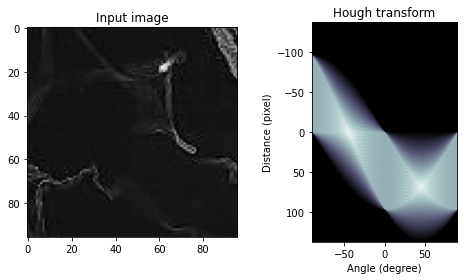

In [41]:
#Lets investigate how the hugh transform performs
from skimage.transform import hough_line
from skimage.draw import line


for i in range(1):
    tmp = X_train[i].reshape(96,96,3)
    img = np.mean(tmp,2)
    img = img-1

    out, angles, d = hough_line(img)

    fix, axes = plt.subplots(1, 2, figsize=(7, 4))

    axes[0].imshow(1-img, cmap=plt.cm.gray)
    axes[0].set_title('Input image')

    angle_step = 0.5 * np.rad2deg(np.diff(angles).mean())
    d_step = 0.5 * np.diff(d).mean()
    bounds = (np.rad2deg(angles[0]) - angle_step,
          np.rad2deg(angles[-1]) + angle_step,
          d[-1] + d_step, d[0] - d_step)

    axes[1].imshow(out, cmap=plt.cm.bone, extent=bounds)
    axes[1].set_title('Hough transform')
    axes[1].set_xlabel('Angle (degree)')
    axes[1].set_ylabel('Distance (pixel)')

    plt.tight_layout()
    plt.savefig('hough_transform.png')

In [163]:
#Familiarizing with hough transforms and peaks
from skimage.transform import hough_line_peaks



#find what the max number of features found in the set is
# max = 0
# for i in range(X_train.shape[0]):
#     tmp = X_train[i].reshape(96,96,3)
#     img = np.mean(tmp,2)
#     img = img-1
#     hspace, angles, dists = hough_line(img)
#     hspace, angles, dists = hough_line_peaks(hspace, angles, dists)
#     features = np.concatenate((hspace,angles,dists),axis=0)
#     if features.shape[0] > max:
#         max = features.shape[0]
# print(max)

#66 is the size of the array we need
hough_train = np.zeros((1500,66))
hough_test = np.zeros((500,66))
hough_val = np.zeros((500,66))

#Create a new input dataset that uses the extracted features, and adds 0 columns 
#if the number of identified features is less than the max
for i in range(X_train.shape[0]):
    tmp = X_train[i].reshape(96,96,3)
    img = np.mean(tmp,2)
    img = img-1
    hspace, angles, dists = hough_line(img)
    hspace, angles, dists = hough_line_peaks(hspace, angles, dists)
    features = np.concatenate((hspace,angles,dists),axis=0)
    if features.shape[0] < 66:
        zeros = np.zeros(((66-features.shape[0])))
        features = np.concatenate((features,zeros),axis=0)
    hough_train[i] = features

#repeat on test data
for i in range(X_test.shape[0]):
    tmp = X_test[i].reshape(96,96,3)
    img = np.mean(tmp,2)
    img = img-1
    hspace, angles, dists = hough_line(img)
    hspace, angles, dists = hough_line_peaks(hspace, angles, dists)
    features = np.concatenate((hspace,angles,dists),axis=0)
    if features.shape[0] < 66:
        zeros = np.zeros(((66-features.shape[0])))
        features = np.concatenate((features,zeros),axis=0)
    hough_test[i] = features
    
for i in range(X_val.shape[0]):
    tmp = X_val[i].reshape(96,96,3)
    img = np.mean(tmp,2)
    img = img-1
    hspace, angles, dists = hough_line(img)
    hspace, angles, dists = hough_line_peaks(hspace, angles, dists)
    features = np.concatenate((hspace,angles,dists),axis=0)
    if features.shape[0] < 66:
        zeros = np.zeros(((66-features.shape[0])))
        features = np.concatenate((features,zeros),axis=0)
    hough_val[i] = features

(66,)


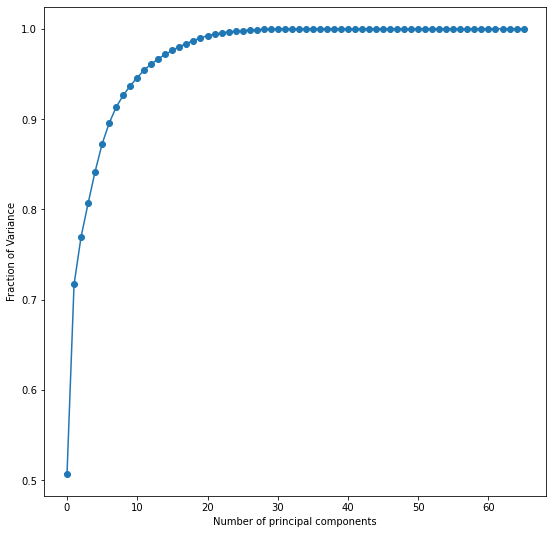

17 components of the total 66 components account for 98% of variance


In [167]:
# lets run PCA on the hough transform features
from sklearn.decomposition import PCA

pcaval = PCA()
pcaval.fit(hough_train)

# compute how much variance is explained by each component
CUMSUM = np.cumsum(pcaval.explained_variance_ratio_)
print(CUMSUM.shape)

plt.figure(figsize=(9,9))
plt.plot(range(66), CUMSUM, marker='o')
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of Variance')
plt.show()

# print out how many components explain at least 95% of the variance
dmax = np.argmax(CUMSUM >= 0.98) + 1
print(dmax,"components of the total", pcaval.explained_variance_ratio_.size, "components account for 98% of variance")

In [44]:
#Lets see what performance can come from hyperparameters now that feature reduction seems good
from sklearn.model_selection import GridSearchCV

n = 17
opt_pipe = Pipeline([('PCA',PCA()),('SVC',SVC())])

opt_clf =GridSearchCV(estimator=opt_pipe,param_grid = {'PCA__n_components':[n],'SVC__kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'SVC__C':[0.01,0.1,1,10]},cv=5)

opt_clf.fit(hough_train,Y_train_flat)

print('Best Parameters are:',opt_clf.best_params_)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

Best Parameters are: {'PCA__n_components': 18, 'SVC__C': 1, 'SVC__kernel': 'rbf'}


C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [168]:
opt_hough = Pipeline([('PCA',PCA(n_components=18)),('Bagging',BaggingClassifier(SVC(C = 1, kernel='rbf',probability=True)))])

opt_hough.fit(hough_train,Y_train_flat)
hough_predictions = opt_hough.predict(hough_val)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.5568
Precision Score is 
 [0.72727273 0.54035088]
Recall Score is 
 [0.13245033 0.95356037]
F1 Score is 
 [0.22408964 0.68980963]


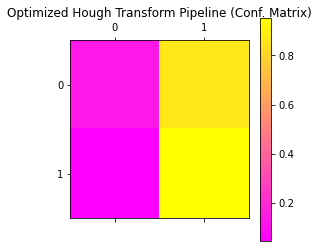

In [46]:
prec_hough = precision_score(Y_test_flat,hough_predictions)
rec_hough = recall_score(Y_test_flat,hough_predictions)
f1_hough = f1_score(Y_test_flat,hough_predictions)
acc_hough = accuracy_score(Y_test_flat,hough_predictions)

hough_probs = opt_hough.predict_proba(hough_train)


#Print the Results
print('Accuracy Score is:', '\n', acc_hough)
print('Precision Score is','\n', prec_hough)
print('Recall Score is', '\n',rec_hough)
print('F1 Score is','\n',f1_hough)

#Confusion and Error Matricies
CM_hough = confusion_matrix(Y_test_flat, hough_predictions)

CM_hough = CM_hough.astype('float') / CM_hough.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_hough, cmap=plt.cm.spring)
plt.title('Optimized Hough Transform Pipeline (Conf. Matrix)')
plt.tight_layout
plt.colorbar()

plt.savefig('Optimized Hugh with PCA cm.png')

In [212]:
#Seems like PCA did not work with the hough transform, perhaps all of the features will show better performance
#Lets compare how the Hough transform performs on the base classifier

base_clf.fit(hough_train,Y_train_flat)
hough_predictions_svc = base_clf.predict(hough_val)

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy Score is: 
 0.542
Precision Score is 
 0.5404814004376368
Recall Score is 
 0.9285714285714286
F1 Score is 
 0.6832641770401107


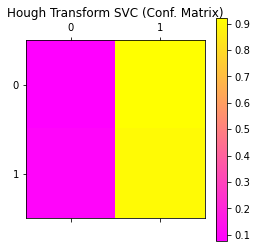

In [213]:
prec_hough_svc = precision_score(Y_val_flat,hough_predictions_svc)
rec_hough_svc = recall_score(Y_val_flat,hough_predictions_svc)
f1_hough_svc = f1_score(Y_val_flat,hough_predictions_svc)
acc_hough_svc = accuracy_score(Y_val_flat,hough_predictions_svc)

hough_probs_svc = base_clf.predict_proba(hough_train)


#Print the Results
print('Accuracy Score is:', '\n', acc_hough_svc)
print('Precision Score is','\n', prec_hough_svc)
print('Recall Score is', '\n',rec_hough_svc)
print('F1 Score is','\n',f1_hough_svc)

#Confusion and Error Matricies
CM_hough_svc = confusion_matrix(Y_test_flat, hough_predictions_svc)

CM_hough_svc = CM_hough_svc.astype('float') / CM_hough_svc.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_hough_svc, cmap=plt.cm.spring)
plt.title('Hough Transform SVC (Conf. Matrix)')
plt.tight_layout
plt.colorbar()
plt.savefig('Hough Transform SVC.png')

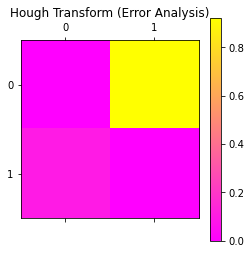

In [232]:
np.fill_diagonal(CM_hough_svc,0)

plt.matshow(CM_hough_svc, cmap=plt.cm.spring)
plt.title('Hough Transform (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.savefig('err_hough.png')

[0.726, 0.716, 0.43, 0.768, 0.72, 0.76, 0.542, 0.5568]


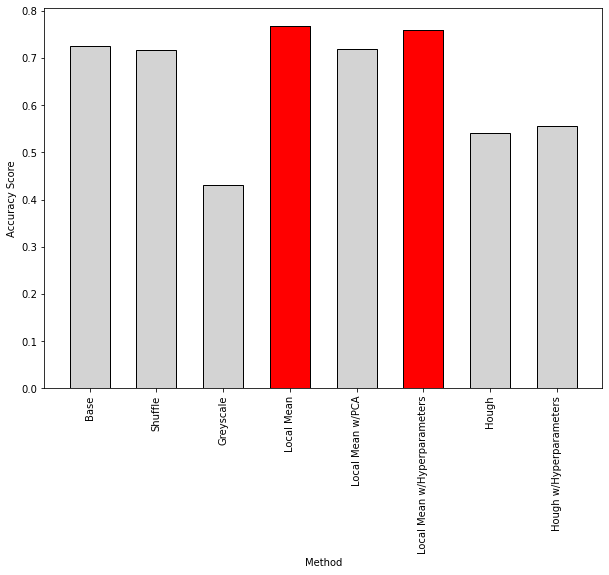

In [224]:
acc_lst = [acc_base, acc_random, acc_grey, acc_scaled, acc_pipe, acc_opt,acc_hough_svc, acc_hough]
print(acc_lst)
labels = ['Base','Shuffle','Greyscale','Local Mean','Local Mean w/PCA','Local Mean w/Hyperparameters','Hough','Hough w/Hyperparameters']

#Accuracy without hyperparameter tuning is the max
plt.figure(figsize=(10,7))
plt.bar(range(8),acc_lst,width=0.6,color = 'lightgrey',edgecolor = 'black')
plt.bar(5,acc_lst[5],color='red',edgecolor='black',width=0.6)
plt.bar(3,acc_lst[3],color='red',edgecolor='black',width=0.6)
plt.ylabel('Accuracy Score')
plt.xlabel('Method')
plt.xticks(range(8),labels =labels, rotation='vertical')
plt.savefig('Accuracy Comparison.png')

Accuracy Score is: 
 0.804
Precision Score is 
 [0.84976526 0.77003484]
Recall Score is 
 [0.73279352 0.87351779]
F1 Score is 
 [0.78695652 0.81851852]
Hyperparameters show slight improvement


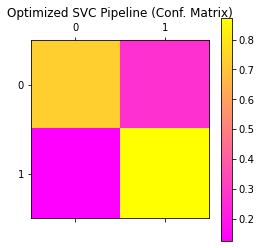

In [202]:
opt_predictions = opt_pipe.predict(X_test_downscale)

prec_opt = precision_score(Y_test_flat,opt_predictions)
rec_opt = recall_score(Y_test_flat,opt_predictions)
f1_opt = f1_score(Y_test_flat,opt_predictions)
acc_opt = accuracy_score(Y_test_flat,opt_predictions)




#Print the Results
print('Accuracy Score is:', '\n', acc_opt)
print('Precision Score is','\n', prec_opt)
print('Recall Score is', '\n',rec_opt)
print('F1 Score is','\n',f1_opt)

#Confusion and Error Matricies
CM_opt = confusion_matrix(Y_test_flat, opt_predictions)

CM_opt = CM_opt.astype('float') / CM_opt.sum(axis=1)[:, np.newaxis]   

plt.matshow(CM_opt, cmap=plt.cm.spring)
plt.title('Optimized SVC Pipeline (Conf. Matrix)')
plt.tight_layout
plt.colorbar()
plt.savefig('optimized_pipeline_test.png')

print('Hyperparameters show slight improvement')

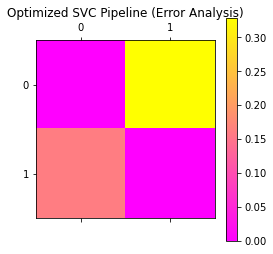

In [225]:
np.fill_diagonal(CM_opt,0)

plt.matshow(CM_opt, cmap=plt.cm.spring)
plt.title('Optimized SVC Pipeline (Error Analysis)')
plt.tight_layout
plt.colorbar()
plt.savefig('err_optimized_test.png')

Figure demonstrates the discrepancies between predict and predict_proba for SVC outlined in the user manual


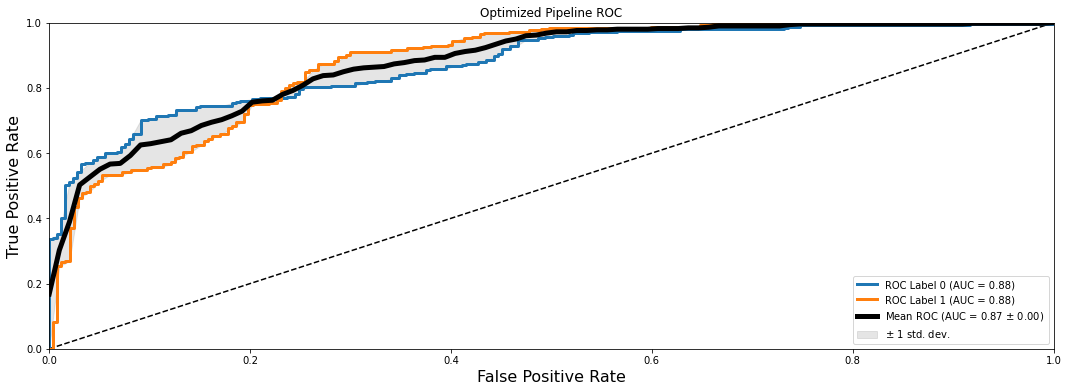

In [172]:
#Testing our best classifier on the Test data
opt_probs = opt_pipe.predict_proba(X_test_downscale)

#ROC Curve
from sklearn.metrics import auc

Fpr_mean = np.linspace(0, 1, 100)
tpr_mean = []
Fpr = []
Tpr = []
AUC = []

for i in range(np.size(opt_probs,1)):
    probs = opt_probs[:,i]
    true = Y_test_flat==i
    fpr,tpr,thresh = roc_curve(true,probs)
    AUC.append(roc_auc_score(true,probs))
    Fpr.append(fpr)
    Tpr.append(tpr)
    tpr_mean.append(np.interp(Fpr_mean,fpr,tpr))

    
# compute the mean and SD for the TPR sequence and the AUC
Tpr_mean = np.mean(tpr_mean, axis=0)
Tpr_stdv = np.std(tpr_mean, axis=0)

mean_auc = auc(Fpr_mean, Tpr_mean)
std_auc = np.std(AUC)

# make the plot: frame
plt.figure(1, figsize=(18, 6))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Optimized Pipeline ROC')

# plot the individual ROC curves
for i in range(0,np.size(opt_probs,1)):
    plt.plot(Fpr[i],Tpr[i], linewidth=3, label=r'ROC Label %d (AUC = %0.2f)' % (i,AUC[i]))

# plot the average ROC curve
plt.plot(Fpr_mean, Tpr_mean, color='k', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth=5)

# plot the backround +/- SD around the average ROC curve
UB = np.minimum(Tpr_mean + Tpr_stdv, 1)
LB = np.maximum(Tpr_mean - Tpr_stdv, 0)
plt.fill_between(Fpr_mean, LB, UB, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')
plt.legend(loc="lower right")
plt.savefig('Optimized ROC curve')
print('Figure demonstrates the discrepancies between predict and predict_proba for SVC outlined in the user manual')

# "in binary classification, a sample may be labeled by predict as belonging to the positive class even 
# if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even 
# if the output of predict_proba is more than 0.5."